### Preprossing

In [1]:
import re
with open('../text/Doyl/sher_eng.txt', encoding='utf-8') as file:
    sher = file.read()
a = sher.find('A STUDY IN SCARLET')
b = sher.find('THE SIGN OF THE FOUR')
study_in_scarlet = sher[a:b]
content = re.split('PART [I]+', study_in_scarlet)[0].strip()
part_1 = re.split('PART [I]+', study_in_scarlet)[1].strip()
part_2 = re.split('PART [I]+', study_in_scarlet)[2].strip()
chapters = re.split('CHAPTER [IVX]+\n .*\n\n\n', part_1)[1:7]

### Tokenization

In [2]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [3]:
def _split_into_sentences(text):
    sentence = [i.strip() for i in sent_tokenize(text)]
    new_sentence = [sentence[0]]
    for s in sentence[1:]:
        if s[0].islower():
            new_sentence[-1] += " " + s
        else:
            new_sentence.append(s)
    return new_sentence

In [4]:
def split_into_words(text):
    sentence = _split_into_sentences(text)
    return [word_tokenize(s) for s in sentence]

### Table and indexing

In [5]:
import pandas as pd

In [6]:
def _flatten(list_of_lists):
    return [elem for inner_list in list_of_lists for elem in inner_list]

In [7]:
def index_table(splited_sent):
    lengths = [len(s) for s in splited_sent]
    sentence_id = _flatten([[i] * length for i, length in enumerate(lengths)])
    token_id = _flatten([list(range(length)) for length in lengths])
    tokens = _flatten(splited_sent)
    return pd.DataFrame({'SentenceID' : sentence_id, 'TokenID' : token_id, 'Token' : tokens},
                                columns=['SentenceID', 'TokenID', 'Token'])

### Speech marks

In [8]:
def _qspeech(token):
    '''Checking the instances of speech'''
    if token == "''" or token == "``":
        return True
    else:
        return False

def _qspeech_ht(token):
    '''Marking heads and tails in speech'''
    if token == "''":
        return "TAIL"
    elif token == "``":
        return "HEAD"
    else:
        return ""

In [9]:
def add_speech_marks(table):
    table['Qspeech'] = table.Token.apply(_qspeech)
    table['QspeechHT'] = table.Token.apply(_qspeech_ht)
    # return table

### classic NER

In [10]:
import pickle
import subprocess
import pandas as pd

In [11]:
def _table_to_list(table):
    with open('tokens.txt', 'w') as tokens_file:
        tokens_file.write(' '.join(list(table.Token)))

### Characters

In [12]:
def _get_heroes(text):
    herolist = []

    for i in frozenset(text.SentenceID):
        s = text[text.SentenceID == i]
        if s[s.QspeechHT == 'TAIL'].empty:
            herolist.append(None)
        else:
            tail = s[s.QspeechHT == 'TAIL'].index[0]
            min_id = s.index.min()
            max_id = s.index.max()
            if (((tail+1 <= max_id) and (s.loc[tail+1, "Tag"] in ['NNP', 'NN', 'PRP']) and 
                ((tail+2 <= max_id) and s.loc[tail+2, "Tag"] in ['VBN', 'VBD']))):
                 herolist.append(s.loc[tail+1, "Token"])
            elif (((tail+2 <= max_id) and (s.loc[tail+2, "Tag"] in ['NNP', 'NN', 'PRP'])) and
                ((tail+1 <= max_id) and s.loc[tail+1, "Tag"] in ['VBN', 'VBD'])):
                herolist.append(s.loc[tail+2, "Token"])
            else:
                herolist.append(None)
    return list(set(herolist))

In [13]:
def add_characters(table):
    hero_list = _get_heroes(table)
    table['IsCharacter'] = table.Token.isin(hero_list)
    # return table

### CoreNLP

In [14]:
import urllib
from bs4 import BeautifulSoup

In [15]:
STANFORD_CORENLP_PATH = "./stanford-corenlp-full-2015-12-09/*"

def _corenlp_xml():
    with open('tokenstaggexs.txt', 'w') as tagged_tokens_file:
        subprocess.call(['java',
                         '-Xmx2g',
                         '-cp', STANFORD_CORENLP_PATH,
    #                      STANFORD_NER_PATH + 'stanford-ner-2015-04-20/stanford-ner.jar',
                         'edu.stanford.nlp.pipeline.StanfordCoreNLP',
                         '-annotators', 
                         'tokenize,ssplit,pos,lemma,ner,parse,sentiment,mention,dcoref,natlog,quote,relation', 
                         '-tokenize.whitespace',
    #                      '-loadClassifier', STANFORD_NER_PATH + 'stanford-ner-2015-04-20/classifiers/english.all.3class.distsim.crf.ser.gz',
    #                      '-tokenizerFactory', 'edu.stanford.nlp.process.WhitespaceTokenizer',
    #                      '-tokenizerOptions', '"tokenizeNLs=true"',
                         '-file', 'tokens.txt',
    #                      '-parse.originalDependencies',
                         '-outputFormat', 'xml'], stdout=tagged_tokens_file, stderr=tagged_tokens_file)
def _corenlp_conll():
    with open('tokenstaggexs.txt', 'w') as tagged_tokens_file:
        subprocess.call(['java',
                         '-Xmx2g',
                         '-cp', STANFORD_CORENLP_PATH,
    #                      STANFORD_NER_PATH + 'stanford-ner-2015-04-20/stanford-ner.jar',
                         'edu.stanford.nlp.pipeline.StanfordCoreNLP',
                         '-annotators', 
                         'tokenize,ssplit,pos,lemma,ner,parse,sentiment,mention,dcoref,natlog,quote,relation', 
                         '-tokenize.whitespace',
    #                      '-loadClassifier', STANFORD_NER_PATH + 'stanford-ner-2015-04-20/classifiers/english.all.3class.distsim.crf.ser.gz',
    #                      '-tokenizerFactory', 'edu.stanford.nlp.process.WhitespaceTokenizer',
    #                      '-tokenizerOptions', '"tokenizeNLs=true"',
                         '-file', 'tokens.txt',
    #                      '-parse.originalDependencies',
                         '-outputFormat', 'conll'], stdout=tagged_tokens_file, stderr=tagged_tokens_file)

### Ner-np

In [16]:
def _add_nercorenlp_id(text):
    text['NerNpID'] = None
    cur_id = -1
    for s in text.SentenceID.unique():
        sentence = text.loc[text.SentenceID == s]
        prev_tag = None
        for i in sentence.index:
            cur_tag = text.loc[i, 'NERtag']
            if cur_tag == 'O':
                pass
            elif cur_tag == prev_tag:
                text.loc[i, 'NerNpID'] = cur_id
            else:
                cur_id += 1
                text.loc[i, 'NerNpID'] = cur_id
            prev_tag = cur_tag

In [17]:
def add_corenlp_conll(table):
    _table_to_list(table)
    _corenlp_conll()
    data = pd.read_csv('tokens.txt.conll', sep='\t', header=None)
    data.columns = ['DepID', 'word', 'Lemma', 'Tag', 'NERtag', 'DepParse', 'DepRel']
    table = pd.concat([table, data[['Lemma','Tag','NERtag','DepID', 'DepParse', 'DepRel']]], axis=1)
    _add_nercorenlp_id(table)
    return table

In [18]:
def _get_xml():
    _corenlp_xml()
    xml_file = './tokens.txt.xml'
    return xml_file

In [19]:
def _get_sent_token_ids():
    xml_file = _get_xml()
    soup = BeautifulSoup(open(xml_file), 'xml')
#     tokens_xml = soup.find_all('token')

#     sent_id_xml = [n['id'] for n in soup.find_all('sentence',{"id":True})]
    token_sent_id_xml = []
    for t in soup.find_all('sentence',{"id":True}):
        tokens = []
        for a in t.find_all('token',{'id':True}):
            tokens.append(a['id'])
        token_sent_id_xml.append(tokens)
    return token_sent_id_xml

In [20]:
def _get_speaker_sentiment():
    xml_file = _get_xml()
    soup1 = BeautifulSoup(open(xml_file))
    t, speaker, sentiment = [], [], []

    for token in soup1.find_all('token'):
        t.append(token.word.get_text())
        if token.speaker != None:
            speaker.append(token.speaker.get_text())
        else:
            speaker.append('')
        sentiment.append(token.sentiment.get_text())
    return speaker, sentiment

In [21]:
def _get_coref():
    xml_file = _get_xml()
    soup = BeautifulSoup(open(xml_file), 'xml')
    coref_list = []
    for cor in soup.coreference.find_all('coreference'):
        coref = []
        for mention in cor.find_all('mention'):
            sent_id = mention.sentence.get_text()
            tok_id = mention.head.get_text()
            coref.append((sent_id, tok_id))
        coref_list.append(coref)
    return coref_list

In [22]:
def _get_coref_table_sent_tok():
    token_sent_id_xml = _get_sent_token_ids()
    sentence_column = _flatten([[i + 1] * len(el) for i, el in enumerate(token_sent_id_xml)])
    token_column = _flatten(token_sent_id_xml)
    token_column = list(map(int, token_column))
    return sentence_column, token_column

def _get_coref_table():
    sentence_column, token_column = _get_coref_table_sent_tok()
    coref_list = _get_coref()
    speaker, sentiment = _get_speaker_sentiment()
    coref_data = pd.DataFrame({'SentenceID' : sentence_column, 'TokenID' : token_column})
    coref_data.set_index(['SentenceID', 'TokenID'], inplace=True)
    coref_data['CorefEntityID'] = None
    
    for i, occurences in enumerate(coref_list):
        for sentence_id, token_id in occurences:
            try:
                coref_data.CorefEntityID.loc[int(sentence_id), int(token_id)] = i
            except:
                print(sentence_id, token_id)
            
    coref_data.reset_index(inplace=True)
    coref_data['Sentiment'] = sentiment
    coref_data['Speaker'] = speaker
    return coref_data

In [23]:
def add_corenlp_xml(table):
    coref_data = _get_coref_table()
    return pd.concat([table, coref_data[['CorefEntityID', 'Sentiment', 'Speaker']]], axis=1)

### Dialogs_ids

In [24]:
def _detect_dialogues(table):
    sentences_with_speakers = list(set(table.loc[table.Speaker!='PER0', 'SentenceID']))

    dialogues = [[sentences_with_speakers[0], None]]
    for i in range(1, len(sentences_with_speakers)):
        if sentences_with_speakers[i]-sentences_with_speakers[i-1] <= 3:
            dialogues[-1][1] = sentences_with_speakers[i]
        else:
            dialogues.append([sentences_with_speakers[i], None])
    return dialogues

In [25]:
def add_dialogues(table):
    dialogues = _detect_dialogues(table)
    table['DialogID'] = None
    for id, dialog in enumerate(dialogues):
        start = table[table.SentenceID == dialog[0]].index[0]
        end = table[table.SentenceID == dialog[1]].index[-1]
        table.loc[start:end, 'DialogID'] = id

# Collect all

In [26]:
def main(text):
    splitted_sent = split_into_words(text)
    print('Text splitted into sentences --- DONE')
    print('Text splitted into words --- DONE')
    table = index_table(splitted_sent)
    print('Text into table --- DONE')
    print('Indexed table --- DONE')
    table = add_corenlp_conll(table)
    print("Corenlp Syntax")
    add_speech_marks(table)
    print("Speech marks")
    add_characters(table)
    print("Characters")
    table = add_corenlp_xml(table)
    print("CoreNLP Speaker, Sentiment")
    add_dialogues(table)
    print("Dialog ids")
    return table

In [27]:
table = main(chapters[0])

Text splitted into sentences --- DONE
Text splitted into words --- DONE
Text into table --- DONE
Indexed table --- DONE
Corenlp Syntax
Speech marks
Characters
CoreNLP Speaker, Sentiment
Dialog ids


In [28]:
table.head()

,SentenceID,TokenID,Token,Lemma,Tag,NERtag,DepID,DepParse,DepRel,NerNpID,Qspeech,QspeechHT,IsCharacter,CorefEntityID,Sentiment,Speaker,DialogID
0,0,0,In,in,IN,O,1,3,case,None,False,,False,None,Neutral,PER0,None
1,0,1,the,the,DT,DATE,2,3,det,0,False,,False,None,Neutral,PER0,None
2,0,2,year,year,NN,DATE,3,6,nmod,0,False,,False,None,Neutral,PER0,None
3,0,3,1878,1878,CD,DATE,4,3,nummod,0,False,,False,None,Neutral,PER0,None
4,0,4,I,I,PRP,O,5,6,nsubj,None,False,,True,0,Neutral,PER0,None


In [29]:
# table[table.DialogID == 1][['Token', 'NERtag', 'Tag', 'IsCharacter', 'CorefEntityID', 'Speaker', 'Sentiment']].to_csv('dialog.csv', sep=';', index=False, encoding='utf-8')

### Анафора

- Character ID
- полученный нером список героев, подправить
    - словарь {Sherlock: 0}, {Holmes: 0}, {Watson : 1}, {Stamford: 2}
    - {I : Watson} только в PER0
- попытка разрешить анафору
    - пройтись по таблице
    - вытащить все токены, у которых CharID == i, и посмотреть их CorefID
    - все множество токенов с такими же CorefID пометить соответсвующим CharID
- смотреть в диалогах, какие charID участвуют

In [30]:
for s in set(table[table.NERtag == 'PERSON'].Token):
    if sum(table.Token == s) > 1:
        print(s, sum(table.Token == s))

Sherlock 5
Watson 2
Stamford 10
Holmes 6


In [31]:
char_id = {'Sherlock' : 'Sherlock', 'Holmes' : 'Sherlock', 'Watson' : 'Watson', 'Stamford' : 'Stamford'}

In [32]:
table[(table.Speaker == 'PER0') & (table.Token == 'I')].Token.index
# То, что нужно пометить Ватсоном

Int64Index([   4,   40,   65,   83,  103,  130,  164,  178,  188,  209,  265,
             269,  289,  319,  346,  354,  379,  424,  465,  489,  514,  521,
             535,  539,  554,  571,  603,  610,  630,  683,  711,  774,  831,
             892,  951, 1088, 1178, 1219, 1334, 1370, 1446, 1458, 1758, 1981,
            2010, 2059, 2316, 2404, 2547, 2728, 2879, 2995, 3009, 3087, 3185,
            3213, 3282, 3368],
           dtype='int64')

In [33]:
def get_char_id(token):
    return char_id.get(token, None)

In [34]:
table['CharID'] = table.Token.apply(get_char_id)

In [35]:
table.loc[((table.Speaker == 'PER0') & (table.Token == 'I')), 'CharID'] = 'Watson'

In [36]:
table[~table.CharID.isnull()][['CharID', 'CorefEntityID']]

# a = table.loc[table.CharID == 'Watson', 'CorefEntityID'].unique()
# table.loc[table.CorefEntityID.isin(a), 'CharID'] = 'Watson' 

# def get_char_id_coref(table, char_id):
for char in set(char_id.values()):
    a = set(table.loc[table.CharID == char, 'CorefEntityID']) - {None}
    table.loc[table.CorefEntityID.isin(a), 'CharID'] = char 

In [37]:
# get_char_id_coref(table, char_id)

In [38]:
table[['Token', 'CharID']].to_csv('chars.csv', sep=';', index=False)

#### Synonyms for say (шеф хотел, чтобы я их нашла и лучше запрогала разбивку на предложения)

In [39]:
from urllib.request import urlopen

url = 'http://www.synonyms-antonyms.com/synonyms-for-said.html'
soup = BeautifulSoup(urlopen(url))

In [40]:
words = [t[0].next.text for t in [y.find_all('strong') for y in soup.find_all('tbody')[1:-5]]]

In [41]:
words = [a.strip() for w in [w.split('\n') for w in words] for a in w]

with open('list_of_words.txt', 'w') as tokens_file:
    tokens_file.write(' '.join(words))

def _corenlp_conll2():
    with open('tokenstaggexs.txt', 'w') as tagged_tokens_file:
        subprocess.call(['java',
                         '-Xmx2g',
                         '-cp', STANFORD_CORENLP_PATH,
                         'edu.stanford.nlp.pipeline.StanfordCoreNLP',
                         '-annotators', 
                         'tokenize,ssplit,pos,lemma',
                         '-tokenize.whitespace',
                         '-file', 'list_of_words.txt',
                         '-outputFormat', 'conll'], stdout=tagged_tokens_file, stderr=tagged_tokens_file)    

In [42]:
_corenlp_conll2()
data = pd.read_csv('list_of_words.txt.conll', sep='\t', header=None)

In [43]:
words = (' '.join(data[2])).split(' ')
# getting say-words from url

In [44]:
words;

In [45]:
table.TokenID[table.QspeechHT == 'TAIL'].index

Int64Index([ 742,  773,  802,  824,  830,  855,  863,  883,  891,  945,  950,
             986, 1007, 1024, 1034, 1077, 1086, 1163, 1177, 1209, 1218, 1282,
            1293, 1329, 1333, 1393, 1429, 1445, 1457, 1501, 1512, 1608, 1614,
            1649, 1655, 1680, 1693, 1722, 1896, 1930, 1956, 1968, 1999, 2009,
            2019, 2047, 2058, 2066, 2102, 2135, 2221, 2276, 2304, 2315, 2399,
            2403, 2508, 2546, 2620, 2632, 2659, 2671, 2696, 2717, 2755, 2814,
            2841, 2868, 2878, 2904, 2910, 2994, 3008, 3061, 3073, 3086, 3105,
            3114, 3145, 3153, 3172, 3183, 3212, 3237, 3253, 3272, 3281, 3318,
            3327, 3363, 3367],
           dtype='int64')

In [46]:
sp3k = []
for s in table.TokenID[table.QspeechHT == 'TAIL'].index:
    if table.Tag.loc[s+1] in ['VBN', 'VBD']:
        sp3k.append(table.Lemma.loc[s+1])
    elif table.Tag.loc[s+2] in ['VBN', 'VBD']:
        sp3k.append(table.Lemma.loc[s+2])

In [47]:
set([el.lower() for el in sp3k])

{'add',
 'answer',
 'ask',
 'continue',
 'cry',
 'do',
 'give',
 'have',
 'hold',
 'laugh',
 'murmur',
 'remark',
 'return',
 'say',
 'seize',
 'shout'}

#### Посчитать количество фраз в диалоговом окне (--- вес ребра)

In [48]:
from collections import Counter

In [49]:
len(set(table[table.DialogID == 1]['SentenceID']))

94

#### Посчитать количество употреблений в окне героя (--- вес узла)

In [50]:
Counter(table[table.DialogID == 1][table.IsCharacter == True]['Lemma'])
# Надо учесть, что I может принадлежать разным сущностям!!!!

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/core/frame.py:1942: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


Counter({'I': 43, 'Sherlock': 4, 'Stamford': 5, 'he': 22})

####  Посчитать «средний» сентимент окна (--- вес ребра)

In [51]:
sentiment_t = table[table.DialogID == 1][table.Sentiment != 'Neutral']['Sentiment']

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/core/frame.py:1942: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [52]:
sum(sentiment_t.isin(['Positive', 'Very positive'])) / len(sentiment_t)

0.69166666666666665

### Do you want some graphs?

In [53]:
import networkx as nx
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
conv_graph = nx.Graph()

In [55]:
n_dialigues = set([t for t in table.DialogID if t is not None])

In [56]:
heroes = []
for i in frozenset([t for t in table.DialogID if t is not None]):
    act = []
    for x in Counter(table[table.DialogID == i][table.IsCharacter == True]['Lemma']):
        if Counter(table[table.DialogID == i][table.IsCharacter == True]['Lemma'])[x] > 1:
            act.append(x)
    heroes.append(act)

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/core/frame.py:1942: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [57]:
heroes = [tuple(h) for h in heroes]
heroes

[('he', 'I', 'Stamford'), ('Sherlock', 'he', 'I', 'Stamford')]

In [58]:
edges = [defaultdict(int) for _ in range(len(n_dialigues))]
for i in n_dialigues:
    for pair in combinations(heroes[i], 2):
        edges[i][frozenset(pair)]

In [59]:
edges

[defaultdict(int,
             {frozenset({'I', 'Stamford'}): 0,
              frozenset({'Stamford', 'he'}): 0,
              frozenset({'I', 'he'}): 0}),
 defaultdict(int,
             {frozenset({'I', 'Stamford'}): 0,
              frozenset({'I', 'Sherlock'}): 0,
              frozenset({'Sherlock', 'he'}): 0,
              frozenset({'Sherlock', 'Stamford'}): 0,
              frozenset({'Stamford', 'he'}): 0,
              frozenset({'I', 'he'}): 0})]

In [60]:
# he = set(table[['Lemma', 'CorefEntityID']][table.DialogID==0][table.Lemma == 'he'].CorefEntityID)
# stamford = set(table[['Lemma', 'CorefEntityID']][table.DialogID==0][table.Lemma == 'Stamford'].CorefEntityID)
# i = set(table[['Lemma', 'CorefEntityID']][table.DialogID==0][table.Lemma == 'I'].CorefEntityID)
# print(stamford & he)
# print(he & i)
# print(i & stamford)

In [61]:
# he = set(table[['Lemma', 'CorefEntityID']][table.DialogID==1][table.Lemma == 'he'].CorefEntityID)
# stamford = set(table[['Lemma', 'CorefEntityID']][table.DialogID==1][table.Lemma == 'Stamford'].CorefEntityID)
# i = set(table[['Lemma', 'CorefEntityID']][table.DialogID==1][table.Lemma == 'I'].CorefEntityID)
# sher = set(table[['Lemma', 'CorefEntityID']][table.DialogID==1][table.Lemma == 'Holmes'].CorefEntityID)
# print(stamford & he)
# print(he & i)
# print(i & sher)
# print(sher & he)
# print(sher)
# print(stamford)

In [62]:
# table[['Lemma', 'CorefEntityID']][table.DialogID==1][table.Lemma == 'Holmes']

In [63]:
# сделать список тex, кто с кем вступал в переговоры

d = 1
for edge in edges[d]:
    conv_graph.add_edge(*edge)

print(nx.info(conv_graph))

Name: 
Type: Graph
Number of nodes: 4
Number of edges: 6
Average degree:   3.0000


/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


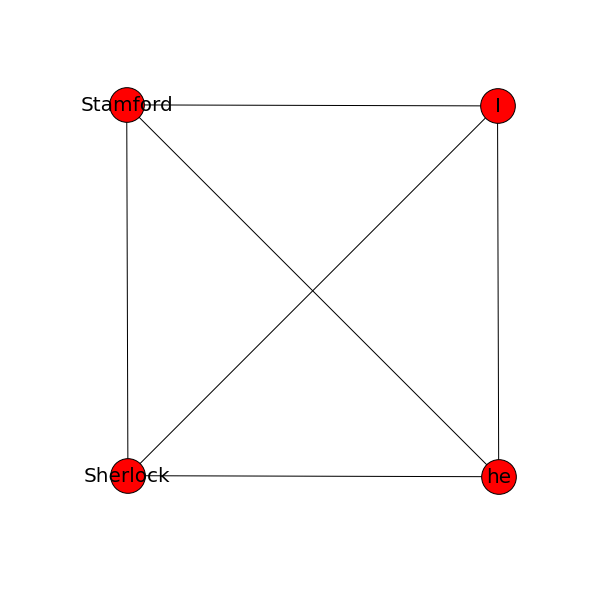

In [64]:
plt.figure(figsize=(10,10))
plt.axis('off')
# weights = graph_weights(conv_graph)
nx.draw_networkx(conv_graph,
                 node_size=1200,
                 font_size=20,
                 with_labels=True,
#                  edge_color=weights,
                 edge_cmap=plt.cm.jet)
#                  edge_vmax = max(weights), edge_vmin=min(weights), alpha=0.7)

In [75]:
len(table[~table.CharID.isnull()])

221

In [79]:
(221-50) / 221
# количество правильно отмеченных тегов
# но число пропущенных целей куда больше.......

0.7737556561085973